## Описание задачи

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Проведем анализ данных о покупках и маркетинговых операциях онлайн магазина

Построим модель и предскажем вероятность покупки в течение 90 дней


In [ ]:
import pandas as pd
import numpy as np

from datetime import date
from dateutil.relativedelta import relativedelta
import seaborn as sns



## Загрузка данных

In [606]:
fldr_1 = 'D:\\Dev\\project_mth_2\\filtered_data\\'
f_names = ['apparel-messages.csv', 'apparel-target_binary.csv', 'apparel-purchases.csv', 'full_campaign_daily_event.csv', 'full_campaign_daily_event_channel.csv']

def rcsv(f_name):
    data = pd.read_csv(fldr_1 + f_name,parse_dates=True)
    print('===='+f_name+'====')
    data.info()
    return data

In [607]:
a_msg = rcsv(f_names[0])
a_targ_b = rcsv(f_names[1])
a_pur = rcsv(f_names[2])
f_cde= rcsv(f_names[3])
f_cde_f = rcsv(f_names[4])

====apparel-messages.csv====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
====apparel-target_binary.csv====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
====apparel-purchases.csv====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------      

### Вывод

Данные загружены. Получены следующие дата фреймы:

        a_msg: apparel-messages.csv --история рекламных рассылок, 12739798 записей
        a_targ_b: apparel-target_binary.csv --Таблица с целевым признаком, совершит ли клиент покупку в течении 90 дней. 49849 записей
        a_pur: apparel-purchases -- история покупок, 202208
        f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
        f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 

В полученных данных видна структура:

    a_targ_b -- корневая таблица.
    a_targ_b связана 1:М к a_msg и a_pur
    a_msg связана с f_cde и f_cde_f по bulk_campaign_id

1. Таблицы не содержат пропуски
2. Целевой признак известен только у 49849 клиентов, тогда как в остальных таблицах записей больше
3. Типы данных нужно будет скорректировать
    



## Предобработка данных

    Выполним преобработку данных, рассмотрим:
    
    Дубли
    Аномалии
    Пропуски
    Типы данных
    Подготовка данных

In [608]:
def drop_dup(data):
    #display(data[data.duplicated()])
    print('Кол-во дублей ДО удаления: ',data.duplicated().sum())
    print('Кол-во ДО удаления: ',len(data))
    data = data.drop_duplicates() 
    print('Кол-во ПОСЛЕ удаления: ',len(data))
    print('')


### Типы данных

In [609]:
##Проставим дату, там где дата
a_msg['date'] = a_msg['date'].astype('datetime64[ns]')
a_msg['created_at'] = a_msg['created_at'].astype('datetime64[ns]')
a_pur['date'] = a_pur['date'].astype('datetime64[ns]')

f_cde['date'] = f_cde['date'].astype('datetime64[ns]')
f_cde_f['date'] = f_cde_f['date'].astype('datetime64[ns]')


### Дубли

In [610]:
##Уберем явные дубли:
print('a_msg: ')
drop_dup(a_msg)
print('a_pur: ')
drop_dup(a_pur)
print('a_targ_b: ')
drop_dup(a_targ_b)
print('f_cde: ')
drop_dup(f_cde)
print('f_cde_f: ')
drop_dup(f_cde_f)

a_msg: 
Кол-во дублей ДО удаления:  48610
Кол-во ДО удаления:  12739798
Кол-во ПОСЛЕ удаления:  12691188

a_pur: 
Кол-во дублей ДО удаления:  73020
Кол-во ДО удаления:  202208
Кол-во ПОСЛЕ удаления:  129188

a_targ_b: 
Кол-во дублей ДО удаления:  0
Кол-во ДО удаления:  49849
Кол-во ПОСЛЕ удаления:  49849

f_cde: 
Кол-во дублей ДО удаления:  0
Кол-во ДО удаления:  131072
Кол-во ПОСЛЕ удаления:  131072

f_cde_f: 
Кол-во дублей ДО удаления:  0
Кол-во ДО удаления:  131072
Кол-во ПОСЛЕ удаления:  131072



In [611]:
##Неявные дубли
a_targ_b['client_id'].duplicated().sum()
#a_targ_b

#display(a_pur)

np.int64(0)

### Аномалии

    a_msg: apparel-messages.csv --история рекламных рассылок, 12739798 записей
    a_targ_b: apparel-target_binary.csv --Таблица с целевым признаком, совершит ли клиент покупку в течении 90 дней. 49849 записей
    a_pur: apparel-purchases -- история покупок, 202208
    f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
    f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 

In [612]:
##a_targ_b
display(a_targ_b.head(5))
a_targ_b['client_len'] = a_targ_b['client_id'].astype(str).str.len()
print(a_targ_b['client_len'].value_counts()) ## длина client_id всегда 19 и тип int
print(a_targ_b['target'].value_counts()) ## target = 1 сильно меньше чем 0(1 из 50 клиентов что-то купит в течении 90 дней). Значения 0 и 1
a_targ_b = a_targ_b.drop('client_len',axis=1)
# a_targ_b аномалий нет

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


client_len
19    49849
Name: count, dtype: int64
target
0    48888
1      961
Name: count, dtype: int64


В a_targ_b аномалий нет

In [613]:
#a_msg
a_msg.info()
display(a_msg.head(5))

print('date min max: ',a_msg['date'].min(), a_msg['date'].max())
print('created_at min max: ',a_msg['created_at'].min(), a_msg['created_at'].max())

display(a_msg['channel'].value_counts()) ## аномалий нет
display(a_msg['event'].value_counts()) ## аномалий нет, какие то события встречаются очень редко, какие-то носят регулярный характер
display(a_msg['bulk_campaign_id'].value_counts()) ##всего 2709 кампаний, некоторые кампании содержат 1 сообщение т.е. индивидуальные рассылки видимо...
#print(a_msg['message_id'].astype(str).str.len().value_counts()) ## у 127 сообщений длина 37, но сами записи выглядят нормально

#аномалий нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


date min max:  2022-05-19 00:00:00 2024-02-15 00:00:00
created_at min max:  2022-05-19 00:14:20 2024-02-15 23:58:40


channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

bulk_campaign_id
14272    104479
14276     63826
4679      50621
11760     45985
14081     44884
          ...  
634           1
1080          1
4899          1
657           1
721           1
Name: count, Length: 2709, dtype: int64

In [614]:
#a_pur: apparel-purchases -- история покупок, 202208
display(a_pur.head(5))
print('date min max: ',a_pur['date'].min(), a_pur['date'].max()) ## похоже как и с маркетинговыми сообщениями, история ведется с мая 2022 года, аномалий не вижу
display(a_pur['quantity'].value_counts()) ## большая часть чеков с 1 покупкой. Аномалий не вижу

display(a_pur['category_ids'].value_counts()) ## часть покупок имеют категорию [] и [None] , по сути пропуск или можно сказать что товары без категорий
a_pur.loc[a_pur['category_ids']=='[]','category_ids'] = '[0]'
a_pur.loc[a_pur['category_ids']=='[None]','category_ids'] = '[0]'
## Представим их как товары 0 категории

print('рассмотрим price:')
display(a_pur['price'].describe())
print('price < 10:',a_pur.query('price < 10'))
display(a_pur.query('price < 10')['category_ids'].value_counts()) ## часть покупок меньше 10 рублей
##Примем то, что такие покупки не существенны, уберем их из набора
#a_pur = a_pur.query('price > 10')
##a_pur готов 

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


date min max:  2022-05-16 00:00:00 2024-02-16 00:00:00


quantity
1     201323
2        751
3         94
4         12
6          5
10         4
15         3
20         3
5          3
25         2
9          2
30         2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['5562', '5599', '5539', '5950']       1
['4', '44', '1600']                    1
['5562', '5597', '5696', '1429']       1
['4', '27', '278', '471']              1
['4', '5837', '5836', '839']           1
Name: count, Length: 933, dtype: int64

рассмотрим price:


count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

price < 10:                   client_id  quantity  price  \
3311    1515915625554355124         1    9.0   
8677    1515915625488303348         1    9.0   
20226   1515915625558928490         1    2.0   
21424   1515915625559762595        10    2.0   
21425   1515915625559762595        10    2.0   
...                     ...       ...    ...   
201965  1515915625584667457         1    7.0   
201989  1515915625641742458         1    7.0   
201990  1515915625641742458         1    7.0   
202068  1515915625955716904         1    7.0   
202069  1515915625955716904         1    7.0   

                            category_ids       date  \
3311    ['5562', '5597', '5642', '1220'] 2022-05-25   
8677     ['5562', '5597', '5642', '887'] 2022-06-03   
20226    ['5562', '5597', '5691', '889'] 2022-07-06   
21424    ['5562', '5597', '5691', '889'] 2022-07-08   
21425    ['5562', '5597', '5691', '889'] 2022-07-08   
...                                  ...        ...   
201965                    

category_ids
[0]                                 5903
['5562', '5597', '5691', '889']      327
['4', '1822', '1821', '1613']        100
['4', '27', '205', '650']             78
['5562', '5536', '5707', '1173']      39
                                    ... 
['5562', '5633', '5646', '765']        1
['5562', '5633', '5569', '581']        1
['5562', '5597', '5566', '913']        1
['5562', '5597', '5565', '1214']       1
['5562', '5589', '5624', '1690']       1
Name: count, Length: 351, dtype: int64

In [615]:
#f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
#print(f_cde.info())
print('date min max:',f_cde['date'].min(),f_cde['date'].max())
display(f_cde.bulk_campaign_id.value_counts())

f_cde.head(5)
##Аномалий нет

date min max: 2022-05-19 00:00:00 2024-05-15 00:00:00


bulk_campaign_id
2499     464
3557     447
5286     427
3401     416
4679     404
        ... 
15146      1
15147      1
13341      1
15149      1
15150      1
Name: count, Length: 3181, dtype: int64

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [616]:
#f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 
display(f_cde_f.head(5))
display(f_cde.bulk_campaign_id.value_counts()) ## количество кампаний такое же как и в f_cde

##Аномалий не вижу

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


bulk_campaign_id
2499     464
3557     447
5286     427
3401     416
4679     404
        ... 
15146      1
15147      1
13341      1
15149      1
15150      1
Name: count, Length: 3181, dtype: int64

### Вывод

Предобработка завершена.

    Типы приведены к норме.
    Дубли выявлены и устранены.
    Аномалии выявлены и устранены

В полученных данных видна структура:

    a_targ_b -- корневая таблица.
    a_targ_b связана 1:М к a_msg и a_pur

    a_msg связана с f_cde и f_cde_f по bulk_campaign_id

## Подготовка новой таблицы

    Для задачи обучения модели, одной таблицы a_targ_b не достаточно.
    
    Необходимо создать новую таблицу, объединив признаки таблиц a_targ_b, a_msg и a_pur.
    a_msg и a_pur сгруппируем по client_id.
    
    Анализ данных в ходе работы показал, что имеет значение дата, когда была совершена операция.
    При этом, данные о покупках и маркетинге заканчиваются примерно весной 2024.
    В ходе применения модели могут появится новые данные, за более свежие даты.
    При создании дополнительных признаков, мы будем ориентироваться не на конкретные даты, а на количество дней и месяцев от последней даты в наборе.
    
    Например, в итоговой таблице будут такие дополнительные признаки:
    message_count_mxdt_6 -- количество сообщений за последние 6 месяцев набора
    message_count_mxdt_12 -- количество сообщений от 12 до 6 месяца до последней даты в наборе
    message_count_mxdt_18 --количество сообщений от 18 до 12 месяцев до последней даты в наборе
    
    lpd_int -- это дата последней покупки клиента (last_purch_date) переведенная в количество дней от самой максимальной даты последней покупки в наборе.

### Таблица маркетинговых активностей клиента

In [617]:
##Отберем не все типы активностей, а встречающиеся хотябы 10тыс раз
s = a_msg['event'].value_counts()
act_events = list(s[s>10000].index)
print(act_events)

['send', 'open', 'click', 'purchase', 'hard_bounce', 'soft_bounce']


In [618]:
mxdt = a_msg['date'].max()

mxdt_6 = mxdt - relativedelta(months=6)
mxdt_12 = mxdt - relativedelta(months=12)
mxdt_18 = mxdt - relativedelta(months=18)
#print(mxdt_6)

#a_msg[a_msg['date'].between(mxdt_6,mxdt)]
#a_msg[a_msg['date'].between(mxdt_12,mxdt_6)]
#a_msg[a_msg['date'].between(mxdt_18,mxdt_12)]
a_msg['message_count'] = 1
a_msg['message_count_mxdt_6'] = ((a_msg['date'].between(mxdt_6,mxdt))).astype(int)
a_msg['message_count_mxdt_12'] = ((a_msg['date'].between(mxdt_12,mxdt_6))).astype(int)
a_msg['message_count_mxdt_18'] = ((a_msg['date'].between(mxdt_18,mxdt_12))).astype(int)

for channel in list(a_msg['channel'].value_counts().index):
    a_msg[channel+'_mxdt_6'] = ((a_msg['channel']==channel) & (a_msg['date'].between(mxdt_6,mxdt))).astype(int)
    a_msg[channel+'_mxdt_12'] = ((a_msg['channel']==channel) & (a_msg['date'].between(mxdt_12,mxdt_6))).astype(int)
    a_msg[channel+'_mxdt_18'] = ((a_msg['channel']==channel) & (a_msg['date'].between(mxdt_18,mxdt_12))).astype(int)
    #pr

for event in act_events:
    a_msg[event+'_mxdt_6'] = ((a_msg['event']==event) & (a_msg['date'].between(mxdt_6,mxdt))).astype(int)
    a_msg[event+'_mxdt_12'] = ((a_msg['event']==event) & (a_msg['date'].between(mxdt_12,mxdt_6))).astype(int)
    a_msg[event+'_mxdt_18'] = ((a_msg['event']==event) & (a_msg['date'].between(mxdt_18,mxdt_12))).astype(int)

In [619]:
a_msg.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at', 'message_count', 'message_count_mxdt_6',
       'message_count_mxdt_12', 'message_count_mxdt_18', 'mobile_push_mxdt_6',
       'mobile_push_mxdt_12', 'mobile_push_mxdt_18', 'email_mxdt_6',
       'email_mxdt_12', 'email_mxdt_18', 'send_mxdt_6', 'send_mxdt_12',
       'send_mxdt_18', 'open_mxdt_6', 'open_mxdt_12', 'open_mxdt_18',
       'click_mxdt_6', 'click_mxdt_12', 'click_mxdt_18', 'purchase_mxdt_6',
       'purchase_mxdt_12', 'purchase_mxdt_18', 'hard_bounce_mxdt_6',
       'hard_bounce_mxdt_12', 'hard_bounce_mxdt_18', 'soft_bounce_mxdt_6',
       'soft_bounce_mxdt_12', 'soft_bounce_mxdt_18'],
      dtype='object')

In [620]:
mxdt = a_msg['date'].max()

mxdt_6 = mxdt - relativedelta(months=6)
mxdt_12 = mxdt - relativedelta(months=12)
mxdt_18 = mxdt - relativedelta(months=18)

for channel in list(a_msg['channel'].value_counts().index):
    a_msg[channel] = (a_msg['channel']==channel).astype(int)

for event in act_events:
    a_msg[event] = (a_msg['event']==event).astype(int)

val_col = [
    'message_count_mxdt_6', 'message_count_mxdt_12','message_count_mxdt_18','message_count',
    'mobile_push_mxdt_6', 'mobile_push_mxdt_12','mobile_push_mxdt_18', 'email_mxdt_6', 'email_mxdt_12','email_mxdt_18',
    'send_mxdt_6', 'send_mxdt_12', 'send_mxdt_18', 'open_mxdt_6',
    'open_mxdt_12', 'open_mxdt_18', 'click_mxdt_6', 'click_mxdt_12',
    'click_mxdt_18', 'purchase_mxdt_6', 'purchase_mxdt_12',
    'purchase_mxdt_18', 'hard_bounce_mxdt_6', 'hard_bounce_mxdt_12',
    'hard_bounce_mxdt_18', 'soft_bounce_mxdt_6', 'soft_bounce_mxdt_12',
    'soft_bounce_mxdt_18']

a_msg_p = a_msg.pivot_table(
    index='client_id',
    values = val_col, aggfunc='sum')

display(a_msg_p.head(5)) ##Таблица маркетинговых активностей по каждому клиенту
a_msg_p.info()
#print(list(filter(lambda x: x==True, a_msg_p.index.duplicated()))) ##проверим что нет дублей по client_id

,click_mxdt_12,click_mxdt_18,click_mxdt_6,email_mxdt_12,email_mxdt_18,email_mxdt_6,hard_bounce_mxdt_12,hard_bounce_mxdt_18,hard_bounce_mxdt_6,message_count,...,open_mxdt_6,purchase_mxdt_12,purchase_mxdt_18,purchase_mxdt_6,send_mxdt_12,send_mxdt_18,send_mxdt_6,soft_bounce_mxdt_12,soft_bounce_mxdt_18,soft_bounce_mxdt_6
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,4,2,35,52,51,0,0,0,177,...,12,0,0,0,31,37,36,0,0,0
1515915625468061003,4,1,1,57,48,46,0,0,0,166,...,1,0,1,0,51,44,44,0,0,0
1515915625468061099,1,6,1,43,64,52,0,2,0,276,...,2,0,0,0,40,87,49,0,0,0
1515915625468061100,0,0,1,0,0,0,0,1,0,434,...,101,0,0,1,60,58,127,0,0,1
1515915625468061170,6,7,1,59,63,64,0,0,0,293,...,15,3,0,0,46,48,139,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   click_mxdt_12          53329 non-null  int64
 1   click_mxdt_18          53329 non-null  int64
 2   click_mxdt_6           53329 non-null  int64
 3   email_mxdt_12          53329 non-null  int64
 4   email_mxdt_18          53329 non-null  int64
 5   email_mxdt_6           53329 non-null  int64
 6   hard_bounce_mxdt_12    53329 non-null  int64
 7   hard_bounce_mxdt_18    53329 non-null  int64
 8   hard_bounce_mxdt_6     53329 non-null  int64
 9   message_count          53329 non-null  int64
 10  message_count_mxdt_12  53329 non-null  int64
 11  message_count_mxdt_18  53329 non-null  int64
 12  message_count_mxdt_6   53329 non-null  int64
 13  mobile_push_mxdt_12    53329 non-null  int64
 14  mobile_push_mxdt_18    53329 non-null  int64
 15  mobile_pu

### Подготовим таблицу статистики по покупкам клиента

In [621]:
print(a_pur['date'].max())
print(a_pur['date'].min())

mxdt = a_pur['date'].max()
mxdt_6 = mxdt - relativedelta(months=6)
mxdt_12 = mxdt - relativedelta(months=12)
mxdt_18 = mxdt - relativedelta(months=18)

a_pur['date_year'] = a_pur['date'].dt.year
a_pur['date_qrt'] = a_pur['date'].dt.quarter

a_pur['price_mxdt_6'] = a_pur[a_pur['date'].between(mxdt_6,mxdt)]['price']
a_pur['price_mxdt_12'] = a_pur[a_pur['date'].between(mxdt_12,mxdt_6)]['price']
a_pur['price_mxdt_18'] = a_pur[a_pur['date'].between(mxdt_18,mxdt_12)]['price']

a_pur['p_count_mx_dt_6'] = (a_pur['date'].between(mxdt_6,mxdt)).astype(int)
a_pur['p_count_mx_dt_12'] = (a_pur['date'].between(mxdt_12,mxdt_6)).astype(int)
a_pur['p_count_mx_dt_18'] = (a_pur['date'].between(mxdt_18,mxdt_12)).astype(int)
a_pur = a_pur.fillna(0)

a_pur_pvt_per = a_pur.pivot_table(index='client_id', 
                              values = ['message_id','price','date','price_mxdt_6','price_mxdt_12','price_mxdt_18','p_count_mx_dt_6','p_count_mx_dt_12','p_count_mx_dt_18'], 
                              aggfunc={
                                  'message_id':'count' ,
                                  'price':'sum','price_mxdt_6':'sum','price_mxdt_12':'sum','price_mxdt_18':'sum','p_count_mx_dt_6':'sum','p_count_mx_dt_12':'sum','p_count_mx_dt_18':'sum',
                                  'date':'max'})

#a_pur_pvt = a_pur_pvt.reset_index()
a_pur_pvt_per = a_pur_pvt_per.rename(columns={'message_id':'purch_count', 'price':'sum_price', 'date':'last_purch_date'})

a_pur_pvt_per.info()
a_pur_pvt_per


2024-02-16 00:00:00
2022-05-16 00:00:00
<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   last_purch_date   49849 non-null  datetime64[ns]
 1   purch_count       49849 non-null  int64         
 2   p_count_mx_dt_12  49849 non-null  int64         
 3   p_count_mx_dt_18  49849 non-null  int64         
 4   p_count_mx_dt_6   49849 non-null  int64         
 5   sum_price         49849 non-null  float64       
 6   price_mxdt_12     49849 non-null  float64       
 7   price_mxdt_18     49849 non-null  float64       
 8   price_mxdt_6      49849 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 3.8 MB


,last_purch_date,purch_count,p_count_mx_dt_12,p_count_mx_dt_18,p_count_mx_dt_6,sum_price,price_mxdt_12,price_mxdt_18,price_mxdt_6
client_id,,,,,,,,,
1515915625468060902,2022-05-27,7,0,0,0,6993.0,0.0,0.0,0.0
1515915625468061003,2023-01-04,7,0,7,0,16235.0,0.0,16235.0,0.0
1515915625468061099,2022-05-17,1,0,0,0,299.0,0.0,0.0,0.0
1515915625468061100,2024-02-10,2,0,0,2,2098.0,0.0,0.0,2098.0
1515915625468061170,2023-06-17,19,19,0,0,33601.0,33601.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1515915626010261344,2024-02-16,6,0,0,6,8994.0,0.0,0.0,8994.0
1515915626010266132,2024-02-14,2,0,0,2,1818.0,0.0,0.0,1818.0
1515915626010439406,2024-02-16,2,0,0,2,198.0,0.0,0.0,198.0


In [622]:
a_pur['date_year'] = a_pur['date'].dt.year
a_pur['date_qrt'] = a_pur['date'].dt.quarter
a_pur_pvt = a_pur.pivot_table(index=['client_id','date_year','date_qrt'], values = ['message_id','price','date'], aggfunc={'message_id':'count' ,'price':'sum','date':'max'})
a_pur_pvt = a_pur_pvt.reset_index()
a_pur_pvt = a_pur_pvt.rename(columns={'message_id':'purch_count', 'price':'sum_price', 'date':'last_purch_date'})

for n in ['2022','2023','2024']:
    a_pur_pvt['sum_'+n] = a_pur_pvt[a_pur_pvt['date_year']==int(n)]['sum_price']
    a_pur_pvt['sum_'+n] = a_pur_pvt['sum_'+n].fillna(0)

    a_pur_pvt['cnt_'+n] = a_pur_pvt[a_pur_pvt['date_year']==int(n)]['purch_count']
    a_pur_pvt['cnt_'+n] = a_pur_pvt['cnt_'+n].fillna(0)

a_pur_pvt = a_pur_pvt.pivot_table(index = 'client_id', 
                                  values = ['last_purch_date','purch_count','sum_price','sum_2022','cnt_2022','sum_2023','cnt_2023','sum_2024','cnt_2024'],
                                  aggfunc={'last_purch_date':'max','purch_count':'sum', 'sum_price':'sum',
                                           'sum_2022':'sum','sum_2023':'sum','sum_2024':'sum','cnt_2022':'sum','cnt_2023':'sum','cnt_2024':'sum'})
#давность последней покупки
#частота покупок
#общая сумма трат
#Динамика покупок

display(a_pur_pvt.head(5)) ## статистика по покупкам
a_pur_pvt.info()

,cnt_2022,cnt_2023,cnt_2024,last_purch_date,purch_count,sum_2022,sum_2023,sum_2024,sum_price
client_id,,,,,,,,,
1515915625468060902,7.0,0.0,0.0,2022-05-27,7,6993.0,0.0,0.0,6993.0
1515915625468061003,0.0,7.0,0.0,2023-01-04,7,0.0,16235.0,0.0,16235.0
1515915625468061099,1.0,0.0,0.0,2022-05-17,1,299.0,0.0,0.0,299.0
1515915625468061100,0.0,0.0,2.0,2024-02-10,2,0.0,0.0,2098.0,2098.0
1515915625468061170,0.0,19.0,0.0,2023-06-17,19,0.0,33601.0,0.0,33601.0


<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cnt_2022         49849 non-null  float64       
 1   cnt_2023         49849 non-null  float64       
 2   cnt_2024         49849 non-null  float64       
 3   last_purch_date  49849 non-null  datetime64[ns]
 4   purch_count      49849 non-null  int64         
 5   sum_2022         49849 non-null  float64       
 6   sum_2023         49849 non-null  float64       
 7   sum_2024         49849 non-null  float64       
 8   sum_price        49849 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 3.8 MB


### Таблица популярных категорий клиента

In [623]:
a_pur['category_ids'].value_counts()
a_pur_cat_n = a_pur.copy()
a_pur_cat_n['cat_cnt'] = 0
a_pur_cat_n = a_pur_cat_n.pivot_table(index = ['client_id','category_ids'],  values='cat_cnt', aggfunc='count')
a_pur_cat_n = a_pur_cat_n.reset_index()
a_pur_cat_n['cat_max_cnt'] = 0

a_pur_cat_n['cat_max_cnt'] = a_pur_cat_n.groupby('client_id')['cat_cnt'].transform('max')
a_pur_cat_n = a_pur_cat_n.query('cat_cnt == cat_max_cnt')
#a_pur_cat_n = a_pur_cat_n.pivot_table(index = ['client_id','cat_f'],  values='cat_f', columns='cat_max_cnt', aggfunc='max')

a_pur_cat_n = a_pur_cat_n.drop_duplicates(subset=['client_id','cat_cnt'])
a_pur_cat_n = a_pur_cat_n.drop('cat_max_cnt', axis=1)
a_pur_cat_n = a_pur_cat_n.set_index('client_id')
a_pur_cat_n.info() ## Таблица наиболее популярных категорий у клиентов
#a_pur_cat_n[['client_id','cat_cnt']].drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category_ids  49849 non-null  object
 1   cat_cnt       49849 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


### Построим общую таблицу

In [624]:
#a_targ_b = a_targ_b.set_index('client_id')
#a_targ_b[a_targ_b['client_id'].duplicated()] ## проверка на дубли. уже была
a_targ_b = a_targ_b.set_index('client_id')
display(a_targ_b)

a_targ_b.info()

,target
client_id,
1515915625468060902,0
1515915625468061003,1
1515915625468061099,0
1515915625468061100,0
1515915625468061170,0
...,...
1515915626010261344,0
1515915626010266132,0
1515915626010439406,0


<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  49849 non-null  int64
dtypes: int64(1)
memory usage: 778.9 KB


In [737]:
#a_pur_pvt ## статистика по покупкам
#a_msg_p ##Таблица маркетинговых активностей по каждому клиенту
#a_targ_b ## таблица с целевым признаком
#a_pur_cat_n ## Таблица наиболее популярных категорий у клиентов

## соединим таблицы
fin_data = a_targ_b.join(a_pur_pvt).join(a_msg_p).join(a_pur_cat_n)

## заполним пропуски
fin_data['last_purch_date'] = fin_data['last_purch_date'].fillna(fin_data['last_purch_date'].mean()) 
fin_data = fin_data.fillna(0)

lpd = fin_data['last_purch_date'].max()
##переведем дату в число дней от последней даты
fin_data['lpd_int'] = (lpd - fin_data['last_purch_date']).dt.days

fin_data['lpd_int']

fin_data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   target                 49849 non-null  int64         
 1   cnt_2022               49849 non-null  float64       
 2   cnt_2023               49849 non-null  float64       
 3   cnt_2024               49849 non-null  float64       
 4   last_purch_date        49849 non-null  datetime64[ns]
 5   purch_count            49849 non-null  int64         
 6   sum_2022               49849 non-null  float64       
 7   sum_2023               49849 non-null  float64       
 8   sum_2024               49849 non-null  float64       
 9   sum_price              49849 non-null  float64       
 10  click_mxdt_12          49849 non-null  float64       
 11  click_mxdt_18          49849 non-null  float64       
 12  click_mxdt_6           49849 non-

### Вывод

Таблица fin_data построена записей 49849, как и в целевой таблице a_targ_b

Кроме этого, созданы таблицы:

    #a_pur_pvt ## статистика по покупкам (количество и сумма за год)
    #a_msg_p ##Таблица маркетинговых активностей по каждому клиенту 49849 
    #a_pur_cat_n ## Таблица наиболее популярных категорий у клиентов 49849 



Предобработка завершена. Финальная таблица для построения модели - fin_data

## Анализ данных

Рассмотрим и визуализируем данные

In [738]:
#a_pur_pvt ## статистика по покупкам
#a_msg_p ##Таблица маркетинговых активностей по каждому клиенту
#a_targ_b ## таблица с целевым признаком
#a_pur_cat_n ## Таблица наиболее популярных категорий у клиентов
print(fin_data.columns)
#fin_data = fin_data.query('sum_price < 10000')
#fin_data = fin_data.query('message_count < 680')
#fin_data = fin_data.query('click_mxdt_6 < 3')
#fin_data = fin_data.query('click_mxdt_12 < 3')

#fin_data = fin_data.query('open_mxdt_6 <5 ')

print(fin_data.target.value_counts())


Index(['target', 'cnt_2022', 'cnt_2023', 'cnt_2024', 'last_purch_date',
       'purch_count', 'sum_2022', 'sum_2023', 'sum_2024', 'sum_price',
       'click_mxdt_12', 'click_mxdt_18', 'click_mxdt_6', 'email_mxdt_12',
       'email_mxdt_18', 'email_mxdt_6', 'hard_bounce_mxdt_12',
       'hard_bounce_mxdt_18', 'hard_bounce_mxdt_6', 'message_count',
       'message_count_mxdt_12', 'message_count_mxdt_18',
       'message_count_mxdt_6', 'mobile_push_mxdt_12', 'mobile_push_mxdt_18',
       'mobile_push_mxdt_6', 'open_mxdt_12', 'open_mxdt_18', 'open_mxdt_6',
       'purchase_mxdt_12', 'purchase_mxdt_18', 'purchase_mxdt_6',
       'send_mxdt_12', 'send_mxdt_18', 'send_mxdt_6', 'soft_bounce_mxdt_12',
       'soft_bounce_mxdt_18', 'soft_bounce_mxdt_6', 'category_ids', 'cat_cnt',
       'lpd_int'],
      dtype='object')
target
0    48888
1      961
Name: count, dtype: int64


count    49849.00000
mean        24.28149
std         40.55615
min          0.00000
25%          0.00000
50%          1.00000
75%         33.00000
max        877.00000
Name: open_mxdt_6, dtype: float64


<Axes: >

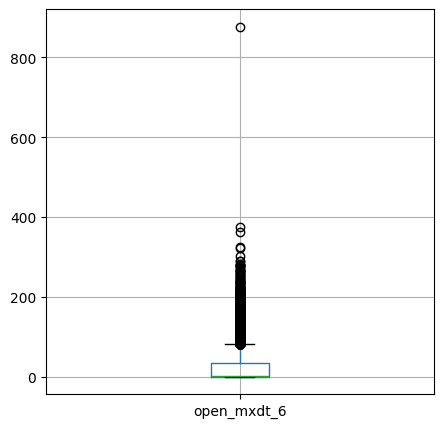

In [739]:
#'click_mxdt_6', 'purchase_mxdt_6', 'purch_count', 'mobile_push_mxdt_6', 'message_count_mxdt_6','open_mxdt_6', 'click_mxdt_12', 'cat_cnt', 'lpd_int','message_count'

print(fin_data['open_mxdt_6'].describe())

fin_data[['open_mxdt_6']].boxplot(figsize=(5,5))

### Таблица fin_data

In [740]:
print(fin_data.columns)
fin_data.describe()

Index(['target', 'cnt_2022', 'cnt_2023', 'cnt_2024', 'last_purch_date',
       'purch_count', 'sum_2022', 'sum_2023', 'sum_2024', 'sum_price',
       'click_mxdt_12', 'click_mxdt_18', 'click_mxdt_6', 'email_mxdt_12',
       'email_mxdt_18', 'email_mxdt_6', 'hard_bounce_mxdt_12',
       'hard_bounce_mxdt_18', 'hard_bounce_mxdt_6', 'message_count',
       'message_count_mxdt_12', 'message_count_mxdt_18',
       'message_count_mxdt_6', 'mobile_push_mxdt_12', 'mobile_push_mxdt_18',
       'mobile_push_mxdt_6', 'open_mxdt_12', 'open_mxdt_18', 'open_mxdt_6',
       'purchase_mxdt_12', 'purchase_mxdt_18', 'purchase_mxdt_6',
       'send_mxdt_12', 'send_mxdt_18', 'send_mxdt_6', 'soft_bounce_mxdt_12',
       'soft_bounce_mxdt_18', 'soft_bounce_mxdt_6', 'category_ids', 'cat_cnt',
       'lpd_int'],
      dtype='object')


,target,cnt_2022,cnt_2023,cnt_2024,last_purch_date,purch_count,sum_2022,sum_2023,sum_2024,sum_price,...,purchase_mxdt_18,purchase_mxdt_6,send_mxdt_12,send_mxdt_18,send_mxdt_6,soft_bounce_mxdt_12,soft_bounce_mxdt_18,soft_bounce_mxdt_6,cat_cnt,lpd_int
count,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,...,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,0.019278,1.637365,2.200245,0.218801,2023-02-19 01:38:30.329193984,4.056410,2131.301611,2442.978555,266.240466,4840.520632,...,0.287789,0.166382,37.312825,37.115148,69.880058,0.035146,0.029650,0.101085,2.433068,361.931593
min,0.000000,0.000000,0.000000,0.000000,2022-05-16 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2022-08-23 00:00:00,1.000000,0.000000,0.000000,0.000000,1499.000000,...,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,233.000000
50%,0.000000,1.000000,0.000000,0.000000,2023-03-05 00:00:00,2.000000,296.000000,0.000000,0.000000,2929.000000,...,0.000000,0.000000,36.000000,37.000000,65.000000,0.000000,0.000000,0.000000,2.000000,348.000000
75%,0.000000,2.000000,2.000000,0.000000,2023-06-28 00:00:00,5.000000,2499.000000,2999.000000,0.000000,5677.000000,...,0.000000,0.000000,58.000000,57.000000,114.000000,0.000000,0.000000,0.000000,3.000000,542.000000
max,1.000000,218.000000,210.000000,92.000000,2024-02-16 00:00:00,346.000000,158042.000000,540408.000000,387583.000000,540408.000000,...,36.000000,44.000000,703.000000,687.000000,894.000000,46.000000,49.000000,64.000000,96.000000,641.000000
std,0.137503,3.568347,4.412015,1.427124,NaN,5.521669,4549.057183,5776.044380,2611.619778,7312.865458,...,0.734211,0.552711,32.378708,32.849162,56.515640,0.777152,0.645718,1.550258,2.318577,185.301691


In [741]:
import seaborn as sns
import matplotlib.pyplot as plt
def acnt_an(fld, cnd, data):

    data = data.query(fld+'>0')
    plt.subplots(figsize=(15, 5))
    sns.histplot(data.query('target == 1 and '+fld+cnd)[fld], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
    sns.histplot(data.query('target == 0 and '+fld+cnd)[fld], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
    plt.title(fld+cnd)
    #plt.xlabel('Прибыль (млн)')
    #plt.ylabel('Плотность')
    #plt.xticks(np.arange(-300, 1300, 100))
    #plt.yticks(np.arange(0, 30, 100))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.2)


In [742]:
fin_data.query('sum_2022 ==0')['target'].value_counts()

target
0    23846
1      544
Name: count, dtype: int64

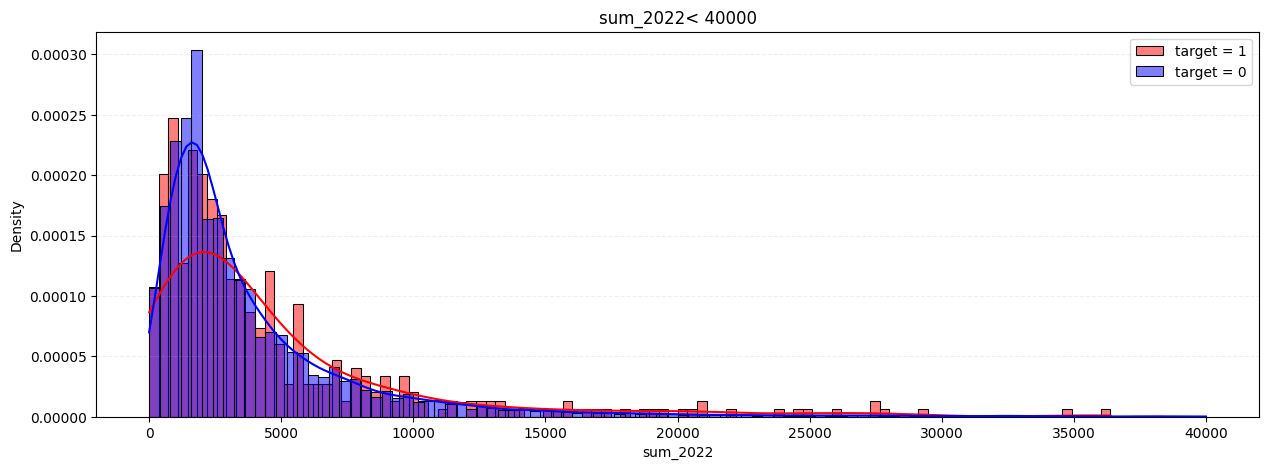

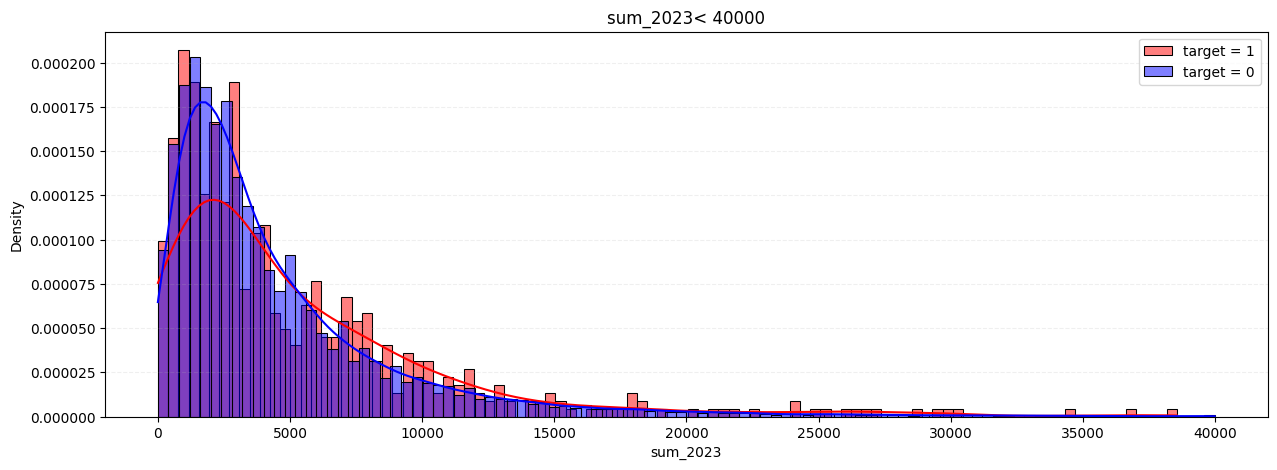

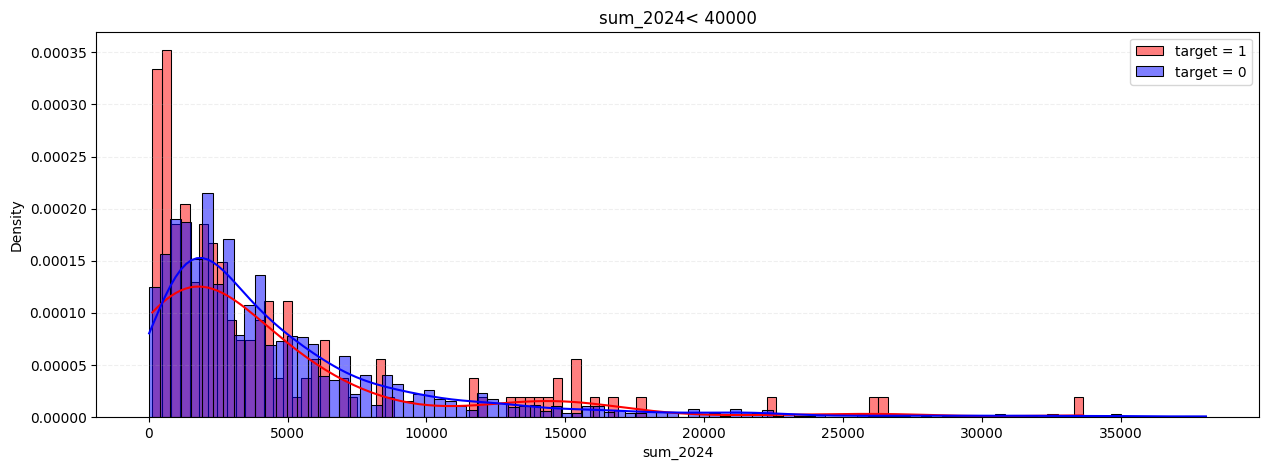

In [743]:
#for n in ['2022_cnt','2023_cnt', '2024_cnt']
for n in ['sum_2022','sum_2023', 'sum_2024']:
    acnt_an(n, '< 40000', fin_data)
#fin_data_sm = fin_data[['2022_sum','2023_sum','2024_sum']].copy()
#fin_data_sm = 



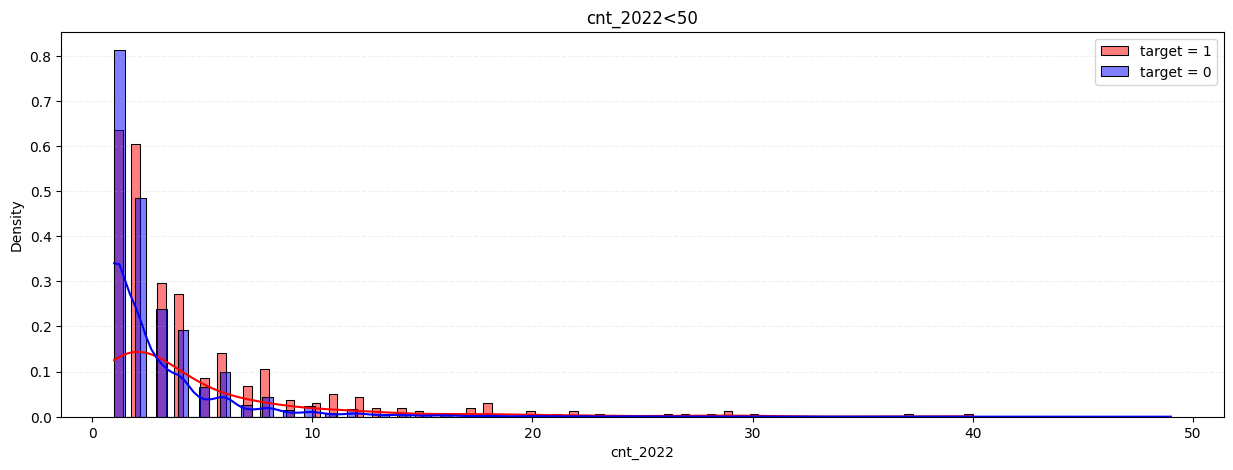

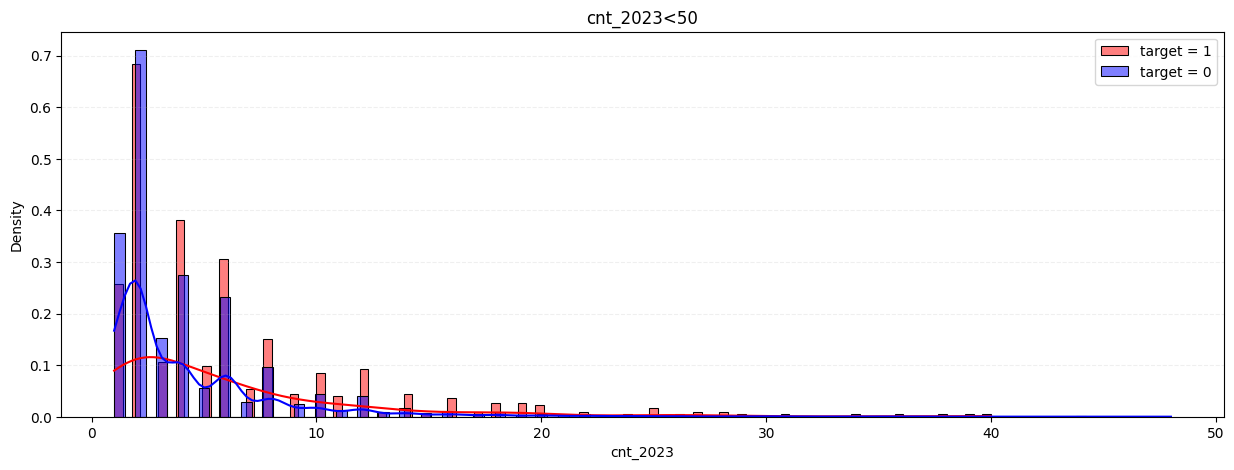

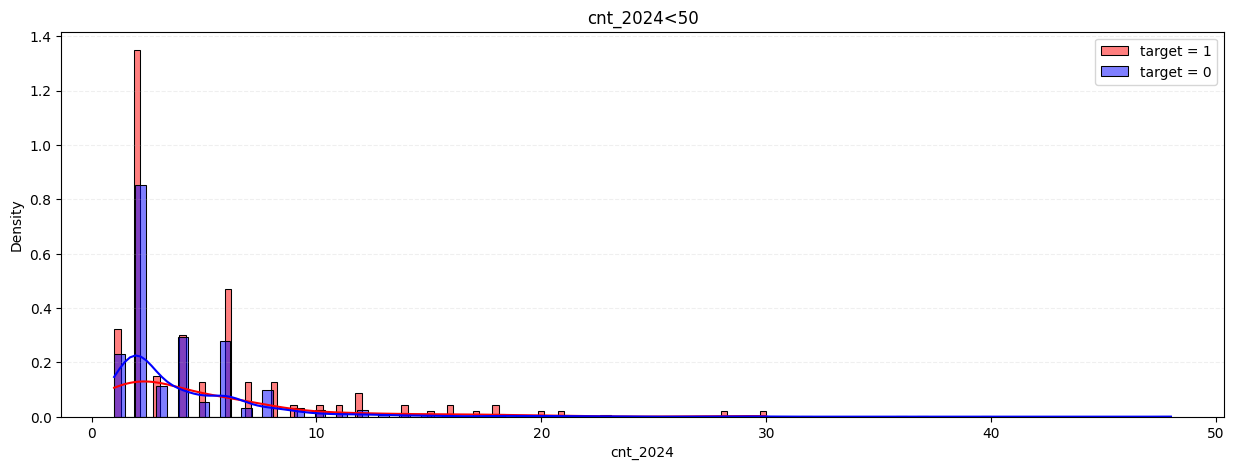

In [744]:
#for n in ['2022_cnt','2023_cnt', '2024_cnt']
for n in ['cnt_2022','cnt_2023', 'cnt_2024']:
    acnt_an(n, '<50', fin_data) ##< 20000
#fin_data_sm = fin_data[['2022_sum','2023_sum','2024_sum']].copy()
#fin_data_sm = 


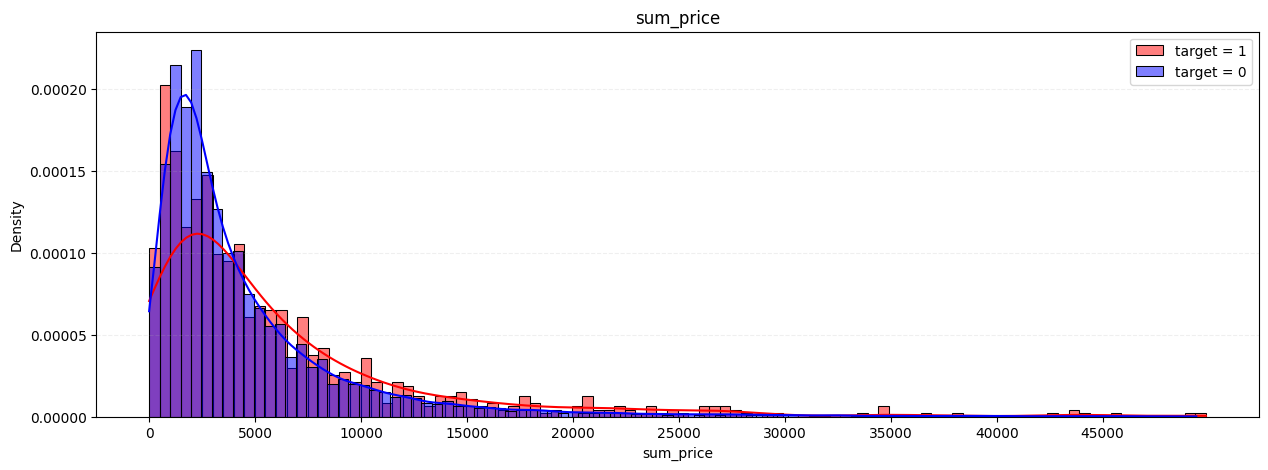

In [745]:


plt.subplots(figsize=(15, 5))
sns.histplot(fin_data.query('target == 1 and sum_price < 50000')['sum_price'], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
sns.histplot(fin_data.query('target == 0 and sum_price < 50000')['sum_price'], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
plt.title('sum_price')
#plt.xlabel('Прибыль (млн)')
#plt.ylabel('Плотность')
plt.xticks(np.arange(0, 50000, 5000))
#plt.yticks(np.arange(0, 30, 100))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)

при общей сумме покупок выше 5000, target=1 больше чем target=0

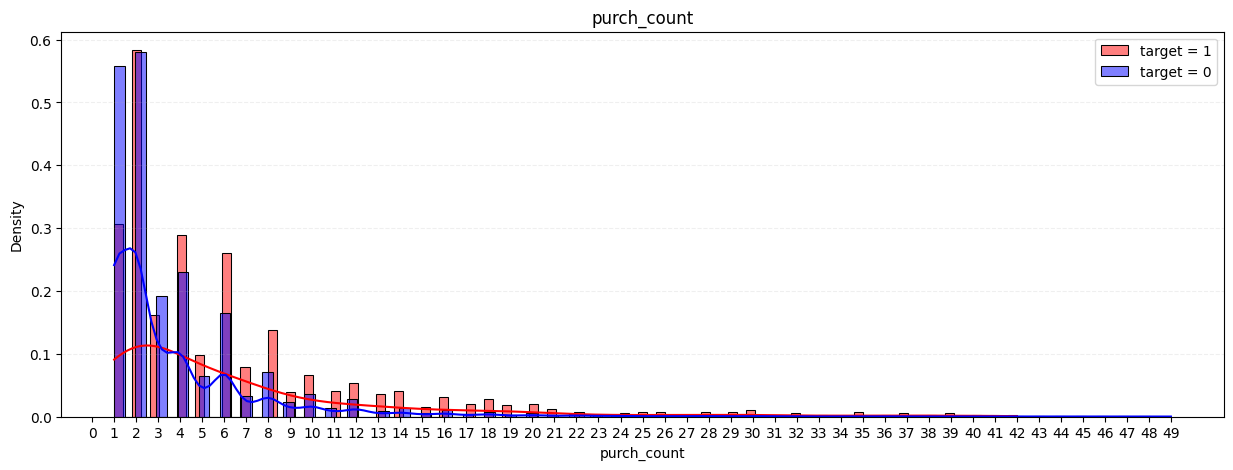

In [746]:
plt.subplots(figsize=(15, 5))
sns.histplot(fin_data.query('target == 1 and purch_count <50')['purch_count'], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
sns.histplot(fin_data.query('target == 0 and purch_count <50')['purch_count'], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
plt.title('purch_count')
#plt.xlabel('Прибыль (млн)')
#plt.ylabel('Плотность')
plt.xticks(np.arange(0, 50, 1))
#plt.yticks(np.arange(0, 30, 100))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)

Видно, что среди клиентов совершивших от 4 и больше покупок, target =1 стабильно больше чем target=0

In [747]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   target                 49849 non-null  int64         
 1   cnt_2022               49849 non-null  float64       
 2   cnt_2023               49849 non-null  float64       
 3   cnt_2024               49849 non-null  float64       
 4   last_purch_date        49849 non-null  datetime64[ns]
 5   purch_count            49849 non-null  int64         
 6   sum_2022               49849 non-null  float64       
 7   sum_2023               49849 non-null  float64       
 8   sum_2024               49849 non-null  float64       
 9   sum_price              49849 non-null  float64       
 10  click_mxdt_12          49849 non-null  float64       
 11  click_mxdt_18          49849 non-null  float64       
 12  click_mxdt_6           49849 non-

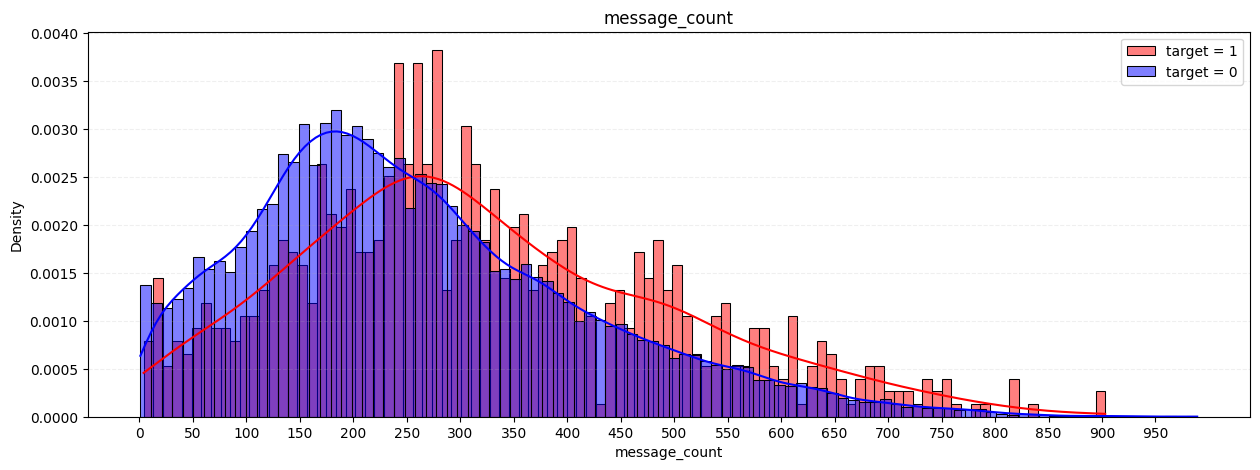

In [748]:
plt.subplots(figsize=(15, 5))
sns.histplot(fin_data.query('target == 1 and message_count > 0 and message_count < 1000')['message_count'], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
sns.histplot(fin_data.query('target == 0 and message_count > 0 and message_count < 1000')['message_count'], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
plt.title('message_count')
#plt.xlabel('Прибыль (млн)')
#plt.ylabel('Плотность')
plt.xticks(np.arange(0, 1000, 50))
#plt.yticks(np.arange(0, 30, 100))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)


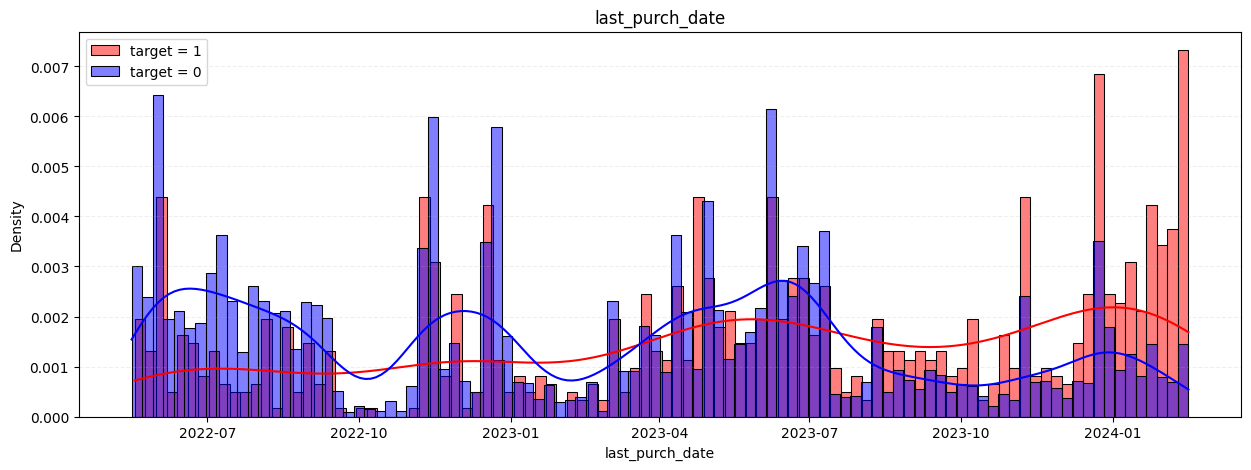

In [749]:
plt.subplots(figsize=(15, 5))
sns.histplot(fin_data.query('target == 1')['last_purch_date'], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
sns.histplot(fin_data.query('target == 0')['last_purch_date'], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
plt.title('last_purch_date')
#plt.xlabel('Прибыль (млн)')
#plt.ylabel('Плотность')
#plt.xticks(np.arange(0, 1000, 50))
#plt.yticks(np.arange(0, 30, 100))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)


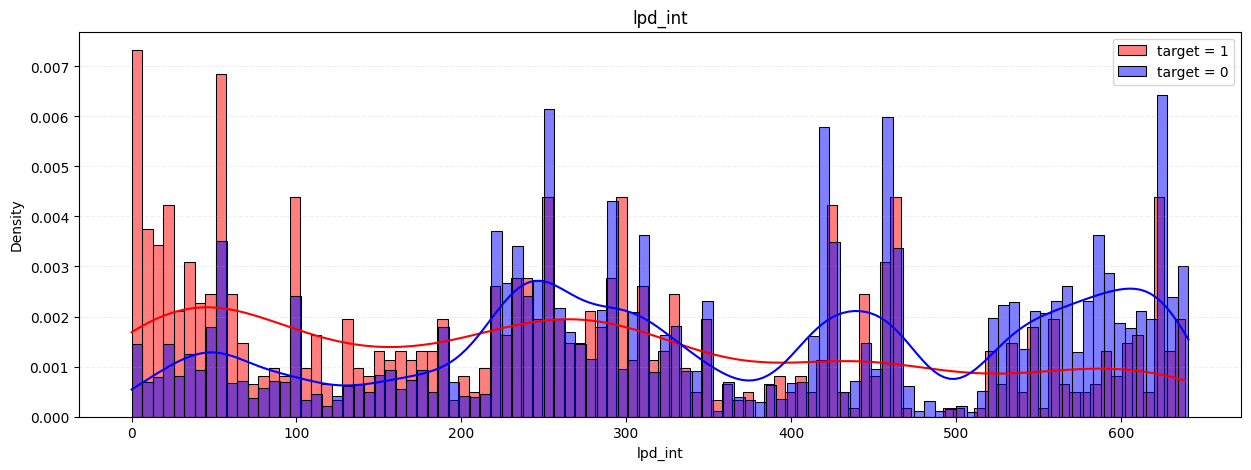

In [750]:
plt.subplots(figsize=(15, 5))
sns.histplot(fin_data.query('target == 1')['lpd_int'], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
sns.histplot(fin_data.query('target == 0')['lpd_int'], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
plt.title('lpd_int')
#plt.xlabel('Прибыль (млн)')
#plt.ylabel('Плотность')
#plt.xticks(np.arange(0, 1000, 50))
#plt.yticks(np.arange(0, 30, 100))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)

Видна зависимость количество маркетинговых акций от таргета. При количестве активностей от 250, target=1 больше

Есть зависимость даты последней попкупки от целевого признака. Клиенты совершавшие покупки в последний период времени с большей вероятностью совершат покупки в 90 дней.


Графики показывают, что при определенных условиях: большей частоте активности клиента, больше покупок, больше реакции на маркетинговые акции, вероятность того, что он совершит покупку - больше

Построим таблицы, чтобы сравнить средние значения признаков в зависимости от целевого признака

In [751]:
typ_mark_an = fin_data[['target','message_count',
                        'message_count_mxdt_6','message_count_mxdt_12','message_count_mxdt_18',
                        'mobile_push_mxdt_6','mobile_push_mxdt_12','mobile_push_mxdt_18']].copy()

typ_mark_an = typ_mark_an.pivot_table(index = 'target',aggfunc='mean')
print('Признаки маркетинговой активности клиентов:')
typ_mark_an

Признаки маркетинговой активности клиентов:


,message_count,message_count_mxdt_12,message_count_mxdt_18,message_count_mxdt_6,mobile_push_mxdt_12,mobile_push_mxdt_18,mobile_push_mxdt_6
target,,,,,,,
0,218.386127,51.070856,50.345320,96.176526,27.313369,21.820897,67.499264
1,285.598335,65.319459,60.620187,135.931322,40.328824,31.917794,104.478668


In [752]:
pur_an = fin_data[['target', 'cnt_2022', 'cnt_2023', 'cnt_2024',
       'purch_count', 'sum_2022', 'sum_2023', 'sum_2024', 'sum_price']]

pur_an = pur_an.pivot_table(index='target', aggfunc='mean')
print('Признаки покупательской активности клиентов:')
pur_an

Признаки покупательской активности клиентов:


,cnt_2022,cnt_2023,cnt_2024,purch_count,sum_2022,sum_2023,sum_2024,sum_price
target,,,,,,,,
0,1.627209,2.165133,0.204754,3.997095,2127.090554,2419.053571,256.387252,4802.531378
1,2.154006,3.986472,0.933403,7.073881,2345.526535,3660.090531,767.493236,6773.110302


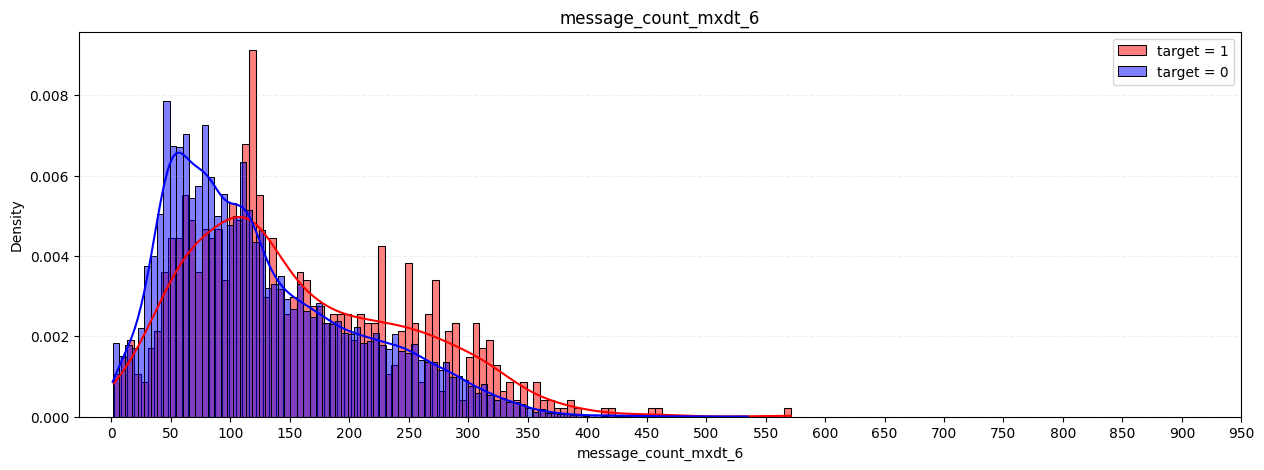

In [753]:
plt.subplots(figsize=(15, 5))
sns.histplot(fin_data.query('target == 1 and message_count_mxdt_6 > 0 and message_count < 1000')['message_count_mxdt_6'], kde=True, stat='density', bins=100, common_norm=False, color='red', label = 'target = 1')
sns.histplot(fin_data.query('target == 0 and message_count_mxdt_6 > 0 and message_count < 1000')['message_count_mxdt_6'], kde=True, stat='density', bins=100, common_norm=False, color='blue', label = 'target = 0')
plt.title('message_count_mxdt_6')
#plt.xlabel('Прибыль (млн)')
#plt.ylabel('Плотность')
plt.xticks(np.arange(0, 1000, 50))
#plt.yticks(np.arange(0, 30, 100))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)


In [754]:
fin_data['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Очень большая разница между классами. Это может повлиять на работу модели.

In [755]:
import matplotlib.pyplot as plt
import seaborn as sns

#анализ данных
import numpy as np
import math
import re

def plt_corr_mtrx(dt):
    num_col = dt.select_dtypes(exclude=['object']).columns ##Только числовые поля
    plt.figure(figsize=(20, 20))
    sns.heatmap(dt[num_col].corr(), annot=True, cmap='cividis');
    plt.show()

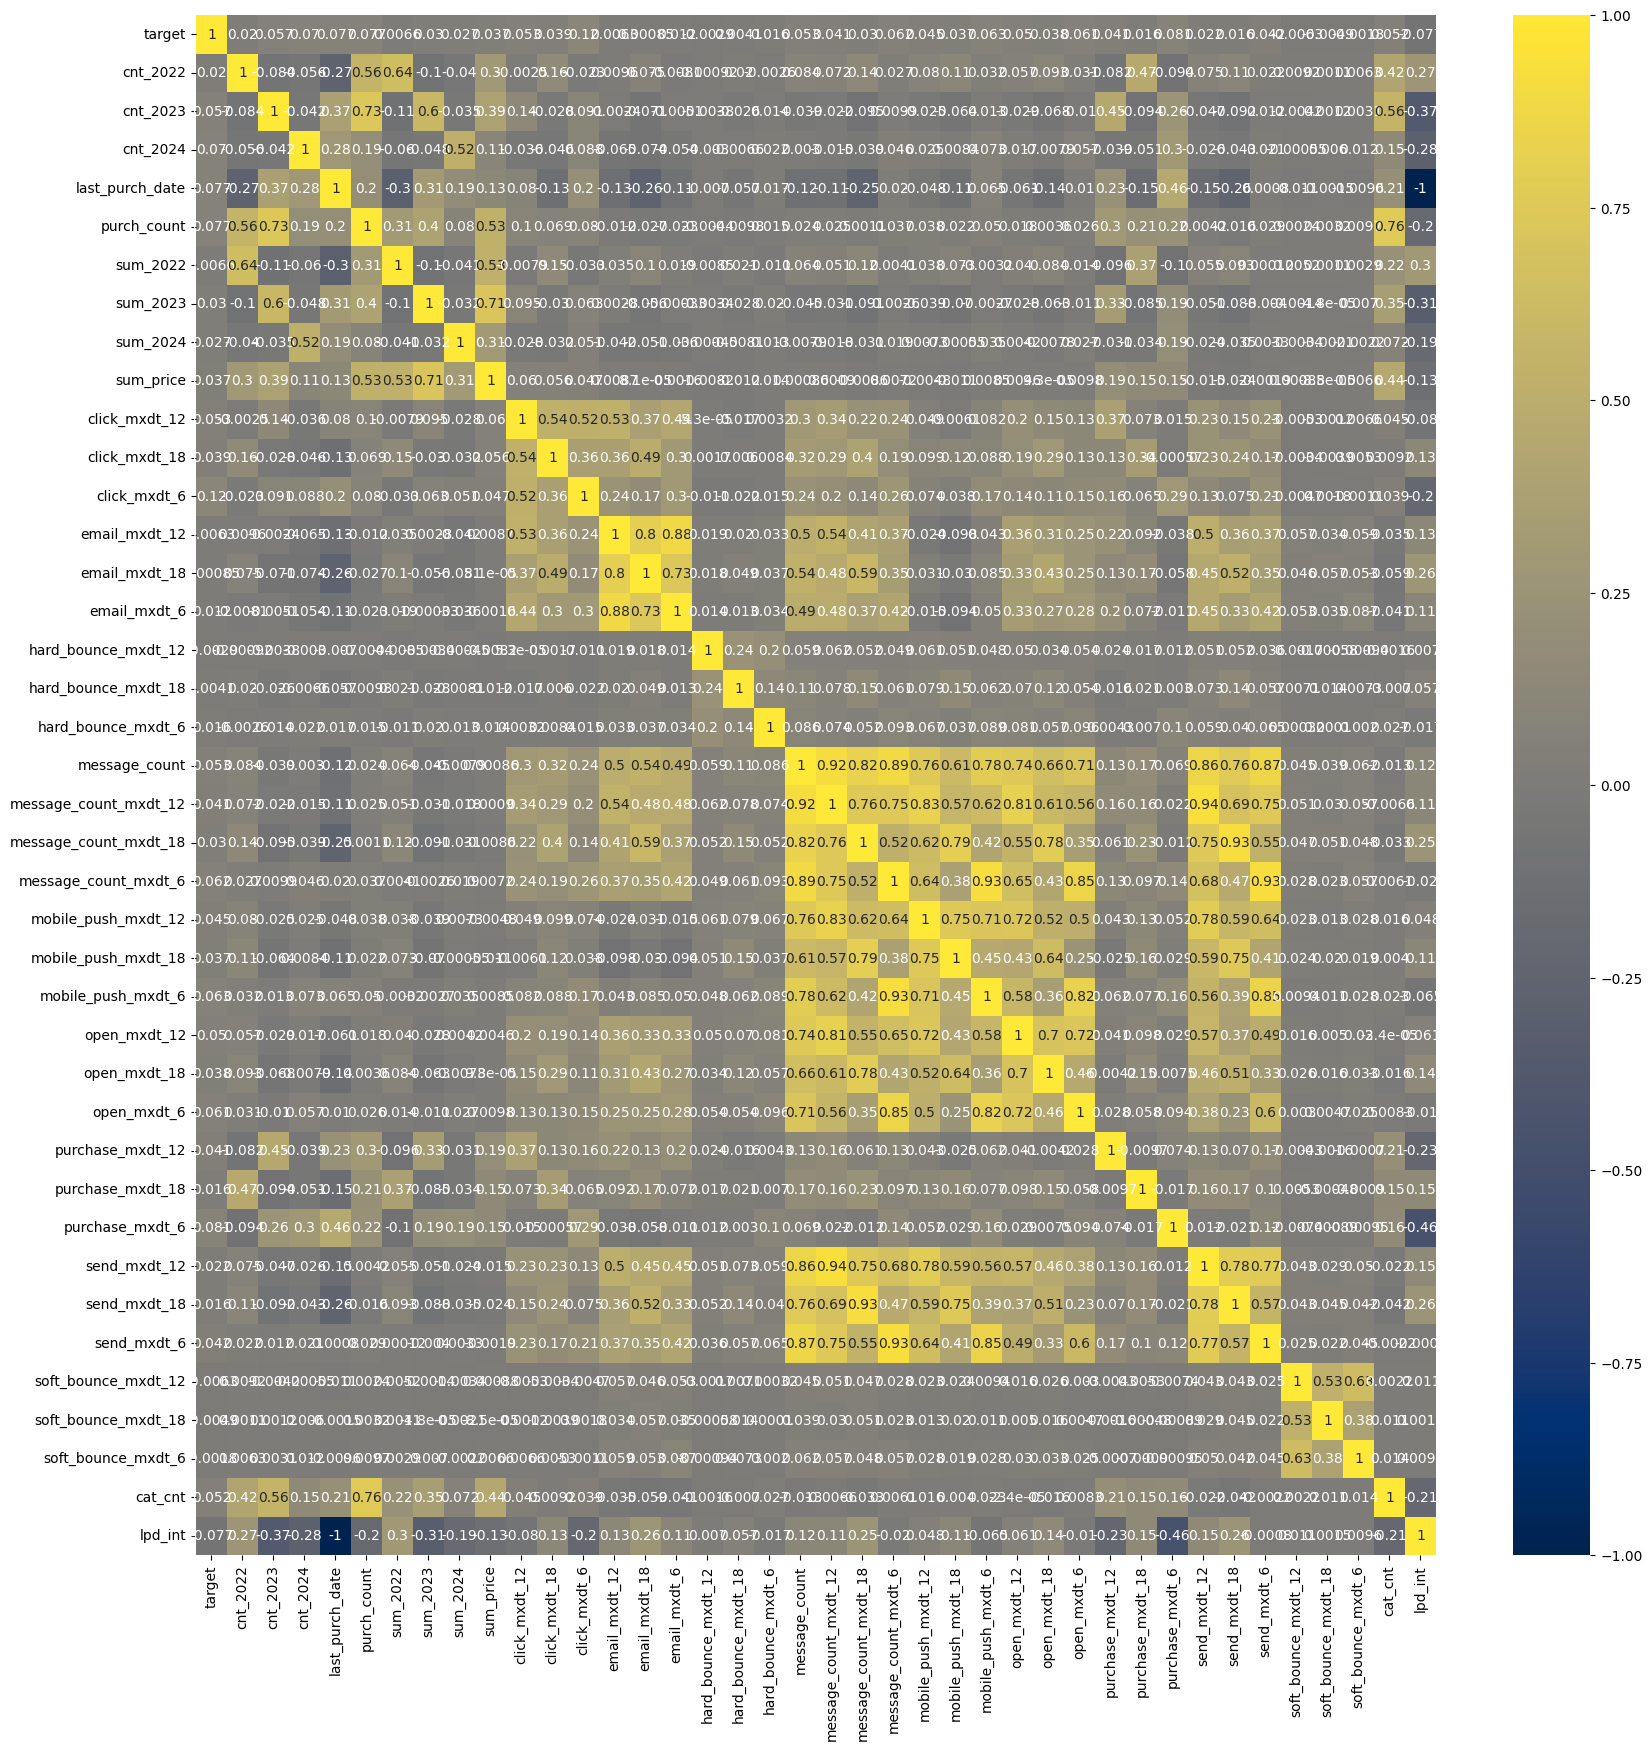

In [756]:
plt_corr_mtrx(fin_data)

### Вывод
Анализ сводной таблицы завершен. можно сделать следующие выводы:

1. Анализ данных показывает, что на целевой признак влияет период времени, в который происходила маркетинговая и покупательская активность клиента.
Особенно видна разница в последний период - за 2024 год. Однако использовать конкретный год и месяц нельзя. На момент исследования данные заканчиваются весной 2024 года. В программу могут задать данные и за 2025 год и позже, в этом случае рассчет будет не верный. Были реализованы признаки с прицелом на время от последней даты в наборе, т.е. за 6 месяцев до, от 12го до 7го, от 18го до 13го и количество дней от даты последней покупки в наборе.

2. Целевой класс не сбалансирован. Клиентов готовых купить, в 50 раз меньше чем тех кто не готов. На этапе подготовки модели, будет использован оверсемплинг данных для обучения
0    48888
1      961

3. Так же видна зависимость целевого признака от количества маркетинговых акций и покупок клиента. С определенного количества активностей, вероятность 1 больше чем 0.
4. Есть зависимость от времени последней покупки. Клиенты сделавшие покупку в заключительный период времени выбоки, имеют большую вероятность к 1.

## Обучение моделей

Зафиксируем основные параметры

In [757]:
#!pip install lightgbm

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from statistics import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

In [758]:
num_col = fin_data.select_dtypes(exclude=['object']).columns
fin_data[num_col].corr()['target'].sort_values(ascending=False)#.index.to_list

target                   1.000000
click_mxdt_6             0.116957
purchase_mxdt_6          0.081065
last_purch_date          0.076910
purch_count              0.076619
cnt_2024                 0.070205
mobile_push_mxdt_6       0.062998
message_count_mxdt_6     0.061691
open_mxdt_6              0.060545
cnt_2023                 0.056763
click_mxdt_12            0.052956
message_count            0.052810
cat_cnt                  0.052405
open_mxdt_12             0.050407
mobile_push_mxdt_12      0.044629
send_mxdt_6              0.041627
message_count_mxdt_12    0.041057
purchase_mxdt_12         0.040571
click_mxdt_18            0.039204
open_mxdt_18             0.037514
sum_price                0.037052
mobile_push_mxdt_18      0.036662
message_count_mxdt_18    0.030153
sum_2023                 0.029544
sum_2024                 0.026910
send_mxdt_12             0.022292
cnt_2022                 0.020300
hard_bounce_mxdt_6       0.016416
purchase_mxdt_18         0.016381
send_mxdt_18  

In [759]:
##Определим срез данных для обучения и основные параметры
fin_data_sampled = fin_data.copy() #oversamp(fin_data)

for n in ['cnt_2022', 'cnt_2023', 'cnt_2024','sum_2022', 'sum_2023', 'sum_2024']:  ##показатели за конкретные годы нам не нужны ,'message_count'
    fin_data_sampled = fin_data_sampled.drop(n,axis=1)
fin_data_sampled.columns

trg = 'target' ## целевой признак

##Определим признаки для шифрования и масштабирования
ohe_columns = ['category_ids'] #
oe_columns = ['category_ids'] #


num_columns = [ 'click_mxdt_6', 'purchase_mxdt_6', 'purch_count', 'mobile_push_mxdt_6', 'message_count_mxdt_6','open_mxdt_6', 'click_mxdt_12', 'cat_cnt', 'lpd_int','message_count'] #
#num_columns = [ 'click_mxdt_6', 'purchase_mxdt_6', 'purch_count', 'lpd_int'] #


#num_columns = list(fin_data_sampled.columns)
#for r in ['target','category_ids', 'sum_price','last_purch_date']: ##,'last_purch_date'
#    num_columns.remove(r)

#display(oe_columns)
display(num_columns)

['click_mxdt_6',
 'purchase_mxdt_6',
 'purch_count',
 'mobile_push_mxdt_6',
 'message_count_mxdt_6',
 'open_mxdt_6',
 'click_mxdt_12',
 'cat_cnt',
 'lpd_int',
 'message_count']

In [760]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

RANDOM_STATE = 42
TEST_SIZE = 0.25


X = fin_data_sampled.drop(trg, axis=1)
X = X[num_columns] ##ohe_columns+
y = fin_data_sampled[trg]

##Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, test_size=TEST_SIZE
)

##Проведем оверсемплинг train выборки, тестовую выборку оставим как есть.

#sampler = SMOTE(random_state=42, k_neighbors=5)
#sampler = ADASYN(random_state=RANDOM_STATE)
Ovsampler = RandomOverSampler(random_state=RANDOM_STATE)
Unsampler = RandomUnderSampler(random_state=RANDOM_STATE)
#X_resample, y_resample = Ovsampler.fit_resample(X, y) 



sampler = SMOTETomek(random_state=42)

X_train, y_train = Ovsampler.fit_resample(X_train, y_train) 


# экземпляр сэмплера


#X_train = X_train.join(y_train)
#X_train = oversamp(X_train)
#print(X_train.target.value_counts())
#y_train = X_train['target']
#X_train = X_train.drop('target',axis=1)
#X_train.info()
#y_train.info()


ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='error') #handle_unknown='ignore' , sparse=False
        )
    ]
) 

oe_pipe = Pipeline(
    [
        (
            'oe', OrdinalEncoder() #handle_unknown='ignore' , sparse=False
        )
    ]
) 

num_pipe = Pipeline(
    [        
        (
            'scaler',  StandardScaler() #handle_unknown='ignore'
        )
        
    ]
) 

In [775]:
from lightgbm import LGBMClassifier

lgb_preprocessor = ColumnTransformer(
    [
        #('oe', oe_pipe, oe_columns),
        ('num', num_pipe,  num_columns)
    ], 
    remainder='passthrough'
)
model_lgb = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=5,
    random_state=RANDOM_STATE
)

In [776]:
lgb_X_train =  lgb_preprocessor.fit_transform(X_train)
lgb_X_test =  lgb_preprocessor.transform(X_test)
#X_test = lgb_preprocessor.transform(X_test)
model_lgb.fit(
    lgb_X_train,y_train    
    )


lgb_train_prd = model_lgb.predict(lgb_X_train)
roc_aud_lgb = roc_auc_score(y_train, lgb_train_prd)
print('roc_auc LGBMClassifier = ',roc_aud_lgb)

[LightGBM] [Info] Number of positive: 36693, number of negative: 36693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 73386, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
roc_auc LGBMClassifier =  0.7141961682064699


c:\DEV\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [777]:
##Проверим модель метрикой roc_auc на тестовом наборе
dt_X_test = lgb_preprocessor.transform(X_test)
lgb_test_prd = model_lgb.predict(dt_X_test)
lgb_test_prd_p = model_lgb.predict_proba(dt_X_test)

roc_aud_lgb_test = roc_auc_score(y_test, lgb_test_prd)
print(roc_aud_lgb_test)

0.6945122175102348


c:\DEV\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\DEV\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


c:\DEV\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


максимальный ошибочный порог: 0.9132984745659628


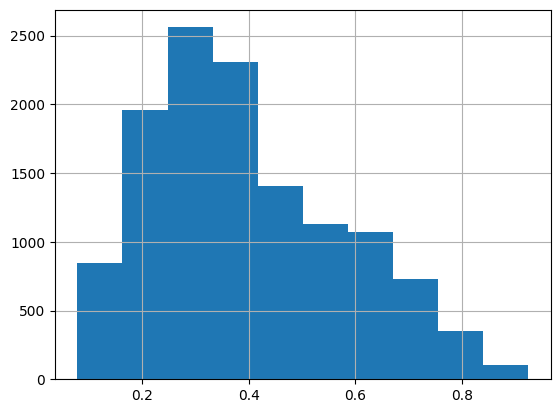

In [764]:
y_proba =  model_lgb.predict_proba(dt_X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data['y_proba'].hist()
print('максимальный ошибочный порог:',(data.query('y_proba>0.5 and y_valid ==0')['y_proba'].max()))

[[8976 3219]
 [  93  175]]
accuracy:  0.734
recall:  0.653
precision:  0.052


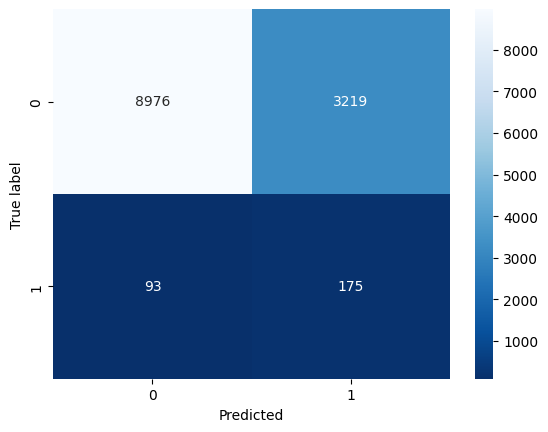

In [765]:
import numpy

thr = 0.5 #0.914
##Наложим новый порог на прогноз
y_pred = (y_proba >= thr).astype(int)

##Оценим прогноз с учетом нового порога
confusion = numpy.zeros((2, 2)).astype(numpy.int64)
for i in range(2):
   for j in range(2):
            confusion[i][j] = numpy.sum(numpy.logical_and(y_test == i,y_pred == j))
        
#Определим TN, FN, FP и TP.
TN = confusion[0][0]
FN = confusion[0][1]
FP = confusion[1][0]
TP = confusion[1][1]

# Выведем результат на экран
print(confusion) 
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)

print('accuracy: ',round(accuracy ,3))
print('recall: ',round(precision ,3))
print('precision: ',round(recall,3))

## Оценка модели

In [766]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model.feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model.coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

In [767]:
feature_names=lgb_preprocessor.get_feature_names_out()
display(feature_names)

array(['num__click_mxdt_6', 'num__purchase_mxdt_6', 'num__purch_count',
       'num__mobile_push_mxdt_6', 'num__message_count_mxdt_6',
       'num__open_mxdt_6', 'num__click_mxdt_12', 'num__cat_cnt',
       'num__lpd_int', 'num__message_count'], dtype=object)

[LightGBM] [Info] Number of positive: 36693, number of negative: 36693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1435
[LightGBM] [Info] Number of data points in the train set: 73386, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


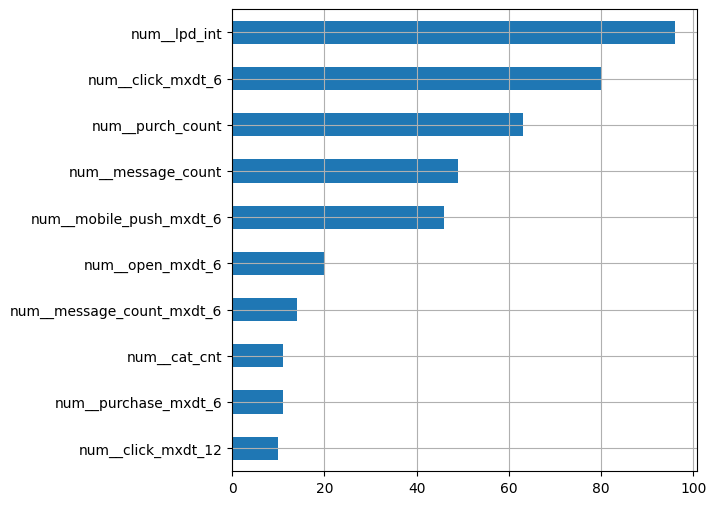

In [768]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

df_X_train = pd.DataFrame(X_train)

plot_features_scores(model=model_lgb, data=df_X_train, target=y_train, column_names=feature_names, model_type='rf')

In [769]:
import shap

model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

c:\DEV\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [770]:
explainer = shap.LinearExplainer(model_lr, X_train)
shap_values = explainer(X_train)
shap_values.feature_names = feature_names.tolist()

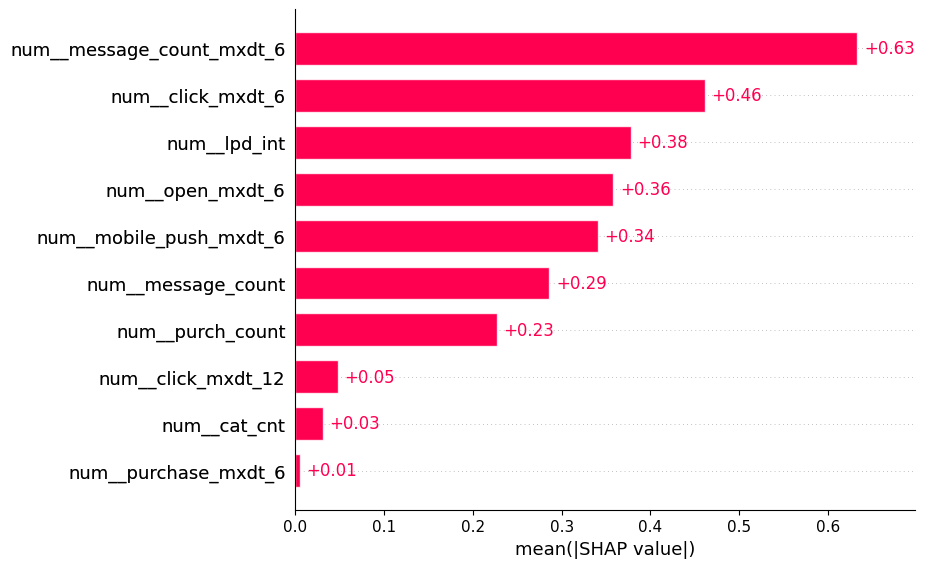

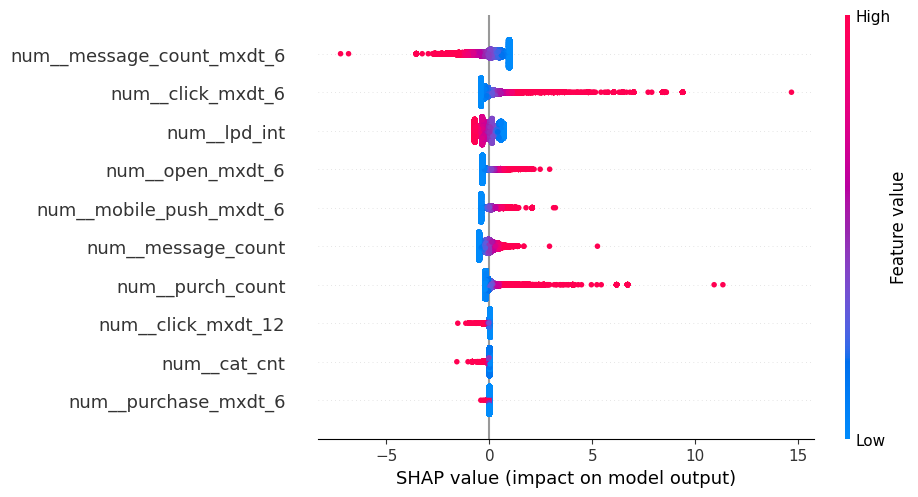

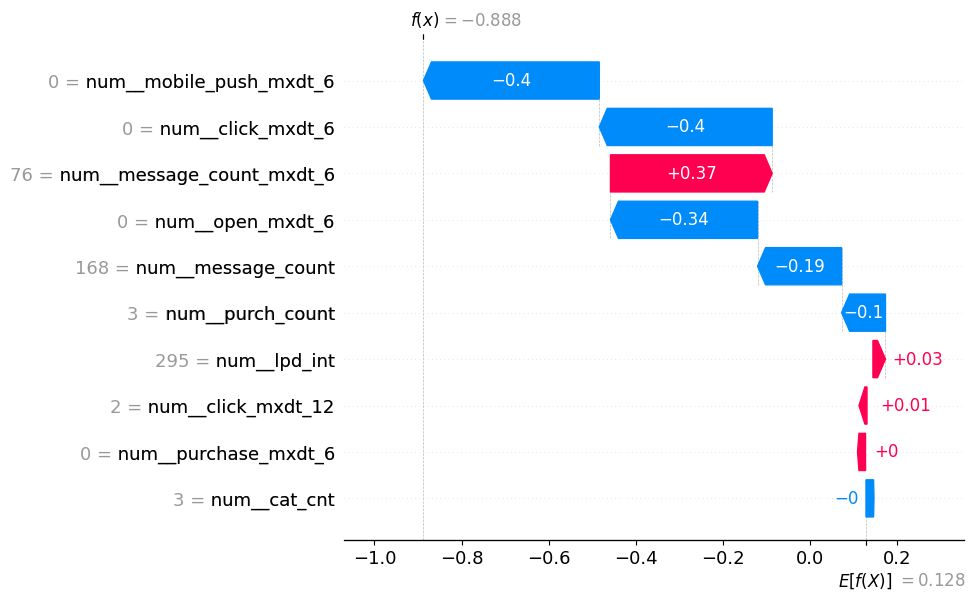

In [771]:
shap.plots.bar(shap_values, max_display=17) 
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[5]) 

## Итоговый вывод